Notebook objective: Train & tune GPBoost Booster + random effect model. Goal is to compare performance & SHAP values with LGBM.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import optuna

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import GroupKFold
import gpboost as gpb

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# Set print options
np.set_printoptions(suppress=True, precision=6, edgeitems = 7)
pd.options.display.float_format = '{:.6f}'.format
pd.set_option('display.max_columns', None)

## Preprocessing

In [3]:
random_state = 1923

In [4]:
# Read data
df = pd.read_csv("./OutputData/training_data.csv")

In [5]:
# Split features, groupings and target
X = df.drop(["life_expectancy", "country", "year"], axis = 1)
G = df[["country", "year"]]
y = df.life_expectancy

In [6]:
# Create CV splitters
cv_outer = GroupKFold(n_splits = 4)
cv_inner = GroupKFold(n_splits = 3)

## Nested crossvalidation

In [7]:
# Initialize lists to store testing results
test_list = []
preds_list = []
resids_list = []
scores_mse = []
scores_rmse = []
scores_mape = []

In [8]:
# Perform nested crossvalidation

# Outer loop
for i, (train_index, test_index) in enumerate(cv_outer.split(X = X, groups = G["country"])):

    # Split train - test
    X_train, G_train, y_train = X.iloc[train_index, ], G.iloc[train_index, ], y[train_index]
    X_test, G_test, y_test = X.iloc[test_index, ], G.iloc[test_index, ], y[test_index]

    # Define tuning objective
    def objective_gpb(trial):

        # Define hyperparameter space
        learning_rate = trial.suggest_float("learning_rate", 0.05, 0.5)
        num_leaves = trial.suggest_int("num_leaves", 2**2, 2**10)
        min_child_samples = trial.suggest_int("min_child_samples", 10, 1000, log = True)
        min_child_weight = trial.suggest_int("min_child_weight", 0.001, 20)
        reg_alpha = trial.suggest_float("l1_reg", 5e-5, 1, log = True)
        reg_lambda = trial.suggest_float("l2_reg", 0, 2)
        subsample = trial.suggest_float("subsample", 0.5, 1)
        colsample_bytree = trial.suggest_float("colsample_bytree", 0.25, 1)
    
        # Store tuning scores & number of rounds
        scores = []
        rounds = []

        # Inner loop (hyperparameter tuning)
        for k, (inner_index, val_index) in enumerate(cv_inner.split(X = X_train, groups = G_train["country"])):
    
            # Split innertrain - val
            X_inner, G_inner, y_inner = X.iloc[inner_index, ], G.iloc[inner_index, ], y[inner_index]
            X_val, G_val, y_val = X.iloc[val_index, ], G.iloc[val_index, ], y[val_index]
        
            # Create model
            model = gpb.GPBoostRegressor(
                n_jobs = 10,
                #device_type = "gpu",
                n_estimators = 5000,
                num_leaves = num_leaves,
                random_state = random_state,
                max_depth = -1,
                min_child_samples = min_child_samples,
                learning_rate = learning_rate,
                min_child_weight = min_child_weight,
                reg_alpha = reg_alpha,
                reg_lambda = reg_lambda,
                colsample_bytree = colsample_bytree
            )
    
            # Create random effects model
            gp_model = gpb.GPModel(
                group_data = G_inner, # Random intercepts for each group
                likelihood = "gaussian",
                seed = random_state
            )
            gp_model.set_prediction_data(group_data_pred = G_val)
    
            # Train model with early stopping
            model.fit(
                X_inner, 
                y_inner,
                gp_model = gp_model, 
                eval_set = [(X_val, y_val)],
                early_stopping_rounds = 50,
                verbose = False)
    
            # Record best number of rounds
            rounds.append(model.best_iteration_)
    
            # Record best score
            scores.append(model.best_score_['valid_0']['l2'])
    
        # Report mean number of rounds
        trial.set_user_attr("n_rounds", (np.mean(rounds)))
        
        return np.mean(scores)

    # Create & perform tuning study
    study_gpb = optuna.create_study(
        sampler = optuna.samplers.TPESampler(seed = random_state),
        study_name = "tune_gpb",
        direction = "minimize"
    )

    optuna.logging.set_verbosity(optuna.logging.ERROR)
    study_gpb.optimize(
      objective_gpb, 
      n_trials = 250,
      show_progress_bar = True)

    # Retrieve best tune
    best_tune = study_gpb.trials_dataframe().sort_values("value", ascending = True)
    best_tune = best_tune[best_tune["state"] == "COMPLETE"].iloc[0]

    # Train GPB model
    train = gpb.Dataset(X_train, y_train)
    test = gpb.Dataset(X_test, y_test)

    gp_model = gpb.GPModel(
        group_data = G_train,
        likelihood = "gaussian",
        seed = random_state
    )
    
    params = {
        "random_state": random_state,
        "n_estimators": int(best_tune["user_attrs_n_rounds"]),
        "num_leaves": best_tune["params_num_leaves"],
        "min_child_samples": best_tune["params_min_child_samples"],
        "learning_rate": best_tune["params_learning_rate"],
        "min_child_weight": best_tune["params_min_child_weight"],
        "reg_alpha": best_tune["params_l1_reg"],
        "reg_lambda": best_tune["params_l2_reg"],
        "colsample_bytree": best_tune["params_colsample_bytree"]
    }

    model = gpb.train(
        params = params,
        train_set = train,
        gp_model = gp_model
    )


    # Save actual values
    test_list.append(y_test)

    # Make predictions on test data
    preds = model.predict(
        X_test, 
        group_data_pred = G_test, 
        predict_var = True, pred_latent = True)
    preds_fixed = preds['fixed_effect']
    preds_random = preds["random_effect_mean"]
    preds = preds_fixed + preds_random
    preds_list.append(preds)

    # Calculate prediction residuals
    resids = y_test - preds
    resids_list.append(resids)

    # Calculate scores
    mse = mean_squared_error(y_test, preds)
    scores_mse.append(mse)

    rmse = mean_squared_error(y_test, preds, squared = False)
    scores_rmse.append(rmse)

    mape = mean_absolute_percentage_error(y_test, preds)
    scores_mape.append(mape)


[I 2023-12-14 17:03:37,785] A new study created in memory with name: tune_gpb
Best trial: 188. Best value: 26.1599: 100%|██████████████████████████████████████████| 250/250 [06:29<00:00,  1.56s/it]
Found `n_estimators` in params. Will use it instead of argument


[GPBoost] [Info] Total Bins 2638
[GPBoost] [Info] Number of data points in the train set: 1237, number of used features: 16
[GPBoost] [Info] [GPBoost with gaussian likelihood]: initscore=69.845432
[GPBoost] [Info] Start training from score 69.845432


Best trial: 218. Best value: 32.5543: 100%|██████████████████████████████████████████| 250/250 [06:49<00:00,  1.64s/it]
Found `n_estimators` in params. Will use it instead of argument


[GPBoost] [Info] Total Bins 2634
[GPBoost] [Info] Number of data points in the train set: 1236, number of used features: 16
[GPBoost] [Info] [GPBoost with gaussian likelihood]: initscore=69.153317
[GPBoost] [Info] Start training from score 69.153317


Best trial: 222. Best value: 25.7692: 100%|██████████████████████████████████████████| 250/250 [05:32<00:00,  1.33s/it]
Found `n_estimators` in params. Will use it instead of argument


[GPBoost] [Info] Total Bins 2661
[GPBoost] [Info] Number of data points in the train set: 1237, number of used features: 16
[GPBoost] [Info] [GPBoost with gaussian likelihood]: initscore=69.133711
[GPBoost] [Info] Start training from score 69.133711


Best trial: 100. Best value: 34.3107: 100%|██████████████████████████████████████████| 250/250 [07:08<00:00,  1.71s/it]
Found `n_estimators` in params. Will use it instead of argument


[GPBoost] [Info] Total Bins 2667
[GPBoost] [Info] Number of data points in the train set: 1237, number of used features: 16
[GPBoost] [Info] [GPBoost with gaussian likelihood]: initscore=69.076637
[GPBoost] [Info] Start training from score 69.076637


In [9]:
# Calculate MSE, RMSE, MAPE
print("MSE:")
print(round(np.mean(scores_mse), 4))

print("RMSE:")
print(round(np.mean(scores_rmse), 4))

print("MAPE:")
print(round(np.mean(scores_mape), 4))

MSE:
62.6377
RMSE:
7.908
MAPE:
0.0966


Worst predictive performance overall, even compared to a fixed effects LM. This, along with the fact that the LMM improves over the LM, suggests that something about the GPBoost algorithm may hamper the booster component's performance.

Should be noted that some nested CV tuning studies may have required more than the 250 trials alotted to converge.

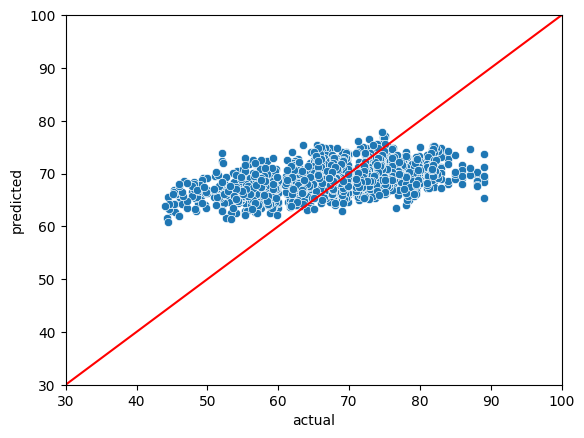

In [10]:
# Plot predicted vs. actual
_ = sns.scatterplot(
    x = np.concatenate(test_list).ravel(),  
    y = np.concatenate(preds_list).ravel()
)
_ = plt.plot([30, 100], [30, 100], c = "red")
_ = plt.xlim(30, 100)
_ = plt.ylim(30, 100)
_ = plt.xlabel("actual")
_ = plt.ylabel("predicted")

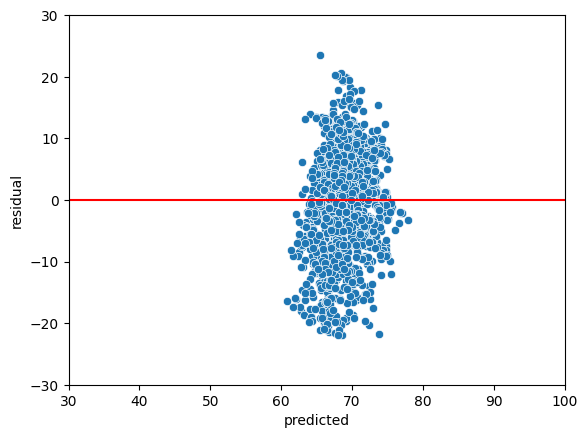

In [11]:
# Predicted vs residual
_ = sns.scatterplot(
    x = np.concatenate(preds_list).ravel(),  
    y = np.concatenate(resids_list).ravel()
)
_ = plt.plot([30, 100], [0, 0], c = "red")
_ = plt.xlim(30, 100)
_ = plt.ylim(-30, 30)
_ = plt.xlabel("predicted")
_ = plt.ylabel("residual")

The predictions are stuck between 60 and 80, and don't seem to react to extreme cases at all.

The plots are probably the most "patternless" out of all 4 models. Still, most observations are either overpredicted or underpredicted.

Interestingly, this is the exact opposite of the LMM plots, and more similar to the LM and LGBM plots.

## Final hyperparameter tuning

In [12]:
# Objective function (Sklearn API)
def objective_gpb(trial):

    # Define hyperparameter space
    learning_rate = trial.suggest_float("learning_rate", 0.05, 0.5)
    num_leaves = trial.suggest_int("num_leaves", 2**2, 2**10)
    min_child_samples = trial.suggest_int("min_child_samples", 10, 1000, log = True)
    min_child_weight = trial.suggest_int("min_child_weight", 0.001, 20)
    reg_alpha = trial.suggest_float("l1_reg", 5e-5, 1, log = True)
    reg_lambda = trial.suggest_float("l2_reg", 0, 2)
    subsample = trial.suggest_float("subsample", 0.5, 1)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.25, 1)

    # Store tuning scores & number of rounds
    scores = []
    rounds = []

    for i, (train_index, val_index) in enumerate(cv_outer.split(X = X, groups = G["country"])):

        # Split train - val
        X_train, G_train, y_train = X.iloc[train_index, ], G.iloc[train_index, ], y[train_index]
        X_val, G_val, y_val = X.iloc[val_index, ], G.iloc[val_index, ], y[val_index]
    
        # Create model
        model = gpb.GPBoostRegressor(
            n_jobs = 10,
            #device_type = "gpu",
            n_estimators = 5000,
            num_leaves = num_leaves,
            random_state = random_state,
            max_depth = -1,
            min_child_samples = min_child_samples,
            learning_rate = learning_rate,
            min_child_weight = min_child_weight,
            reg_alpha = reg_alpha,
            reg_lambda = reg_lambda,
            colsample_bytree = colsample_bytree
        )

        # Create random effects model
        gp_model = gpb.GPModel(
            group_data = G_train, # Random intercepts for each group
            likelihood = "gaussian",
            seed = random_state
        )
        gp_model.set_prediction_data(group_data_pred = G_val)

        # Train model with early stopping
        model.fit(
            X_train, 
            y_train,
            gp_model = gp_model, 
            eval_set = [(X_val, y_val)],
            early_stopping_rounds = 50,
            verbose = False)

        # Record best number of rounds
        rounds.append(model.best_iteration_)

        # Record best score
        scores.append(model.best_score_['valid_0']['l2'])

    # Report mean number of rounds
    trial.set_user_attr("n_rounds", (np.mean(rounds)))
    
    return np.mean(scores)


In [13]:
# Create study
study_gpb = optuna.create_study(
  sampler = optuna.samplers.TPESampler(seed = random_state),
  study_name = "tune_gpb",
  direction = "minimize"
)

In [14]:
# Perform study
optuna.logging.set_verbosity(optuna.logging.ERROR)
study_gpb.optimize(
  objective_gpb, 
  n_trials = 500,
  show_progress_bar = True)

Best trial: 209. Best value: 56.6124: 100%|██████████████████████████████████████████| 500/500 [21:16<00:00,  2.55s/it]


In [15]:
# Save tuning log
trials_gpb = study_gpb.trials_dataframe().sort_values("value", ascending = True)
trials_gpb.to_csv("./OutputData/trials_gpb.csv", index = False)

## Diagnostics & inference

In [16]:
# Load best 5 tunes
best_tunes = pd.read_csv("./OutputData/trials_gpb.csv")
best_tunes = best_tunes[best_tunes["state"] == "COMPLETE"].iloc[0:5]
best_tune = best_tunes.iloc[0]

In [17]:
best_tunes

,number,value,datetime_start,datetime_complete,duration,params_colsample_bytree,params_l1_reg,params_l2_reg,params_learning_rate,params_min_child_samples,params_min_child_weight,params_num_leaves,params_subsample,user_attrs_n_rounds,state
0,209,56.612370,2023-12-14 17:38:05.234142,2023-12-14 17:38:10.057034,0 days 00:00:04.822892,0.259742,0.000636,1.114031,0.487651,105,2,788,0.766482,540.500000,COMPLETE
1,242,59.038604,2023-12-14 17:39:49.541444,2023-12-14 17:39:53.737827,0 days 00:00:04.196383,0.274391,0.000206,1.138488,0.431523,113,2,765,0.710872,536.000000,COMPLETE
2,349,59.193956,2023-12-14 17:44:32.818402,2023-12-14 17:44:37.184238,0 days 00:00:04.365836,0.265432,0.011917,1.120171,0.390775,113,0,789,0.699929,596.750000,COMPLETE
3,238,59.693941,2023-12-14 17:39:37.300216,2023-12-14 17:39:41.967244,0 days 00:00:04.667028,0.252893,0.000169,1.144311,0.416152,117,3,793,0.715040,626.750000,COMPLETE
4,269,60.129488,2023-12-14 17:41:00.579883,2023-12-14 17:41:04.795107,0 days 00:00:04.215224,0.277333,0.000392,1.231554,0.400050,112,5,739,0.685349,562.000000,COMPLETE


In [18]:
# Preprocess data for final model
train = gpb.Dataset(X, y)

In [19]:
# Create random effects model
gp_model = gpb.GPModel(
        group_data = G,
        likelihood = "gaussian",
        seed = random_state
    )

In [20]:
# Create params dict
params = {
    "random_state": random_state,
    "n_estimators": int(best_tune["user_attrs_n_rounds"]),
    "num_leaves": best_tune["params_num_leaves"],
    "min_child_samples": best_tune["params_min_child_samples"],
    "learning_rate": best_tune["params_learning_rate"],
    "min_child_weight": best_tune["params_min_child_weight"],
    "reg_alpha": best_tune["params_l1_reg"],
    "reg_lambda": best_tune["params_l2_reg"],
    "colsample_bytree": best_tune["params_colsample_bytree"]
}

In [21]:
# Train booster
model = gpb.train(
    params = params,
    train_set = train,
    gp_model = gp_model
)

Found `n_estimators` in params. Will use it instead of argument


[GPBoost] [Info] Total Bins 2713
[GPBoost] [Info] Number of data points in the train set: 1649, number of used features: 16
[GPBoost] [Info] [GPBoost with gaussian likelihood]: initscore=69.302304
[GPBoost] [Info] Start training from score 69.302304


In [22]:
# Get fitted values
fitted = model.predict(
    X, 
    group_data_pred = G, 
    predict_var = True, pred_latent = True)

In [23]:
# Get fitted values' components
fitted_fixed = fitted['fixed_effect']
fitted_random = fitted["random_effect_mean"]
fitted_total = fitted_fixed + fitted_random

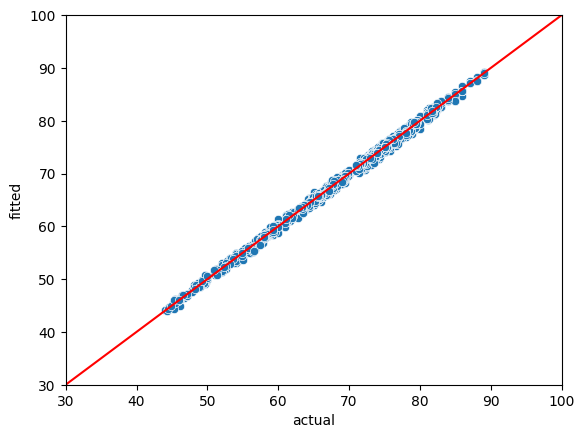

In [24]:
# Plot fitted vs. actual
_ = sns.scatterplot(x = y,  y = fitted_total)
_ = plt.plot([30, 100], [30, 100], c = "red")
_ = plt.xlim(30, 100)
_ = plt.ylim(30, 100)
_ = plt.xlabel("actual")
_ = plt.ylabel("fitted")

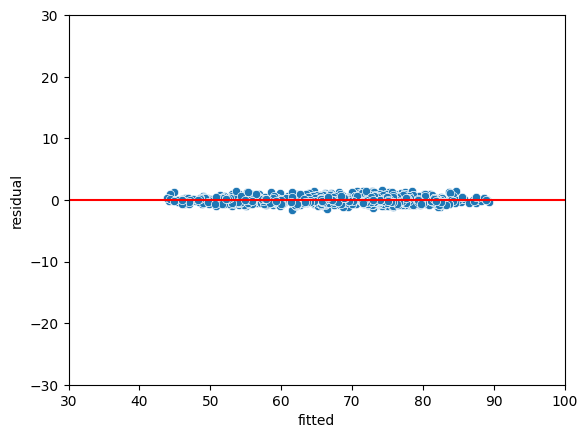

In [26]:
# Fitted vs residual
fitted_resids = y - fitted_total
_ = sns.scatterplot(x = fitted_total, y = fitted_resids)
_ = plt.plot([30, 100], [0, 0], c = "red")
_ = plt.xlim(30, 100)
_ = plt.ylim(-30, 30)
_ = plt.xlabel("fitted")
_ = plt.ylabel("residual")

The GPB model yields a perfect fit of the training data, much unlike the other models. Maybe the nature of the GPBoost algorithm somehow causes overfitting, despite tuning the booster parameters?

In [27]:
pd.Series(fitted_fixed).describe()

count   1649.000000
mean      69.142659
std        2.687496
min       57.851262
25%       68.058371
50%       69.333902
75%       70.545608
max       80.000624
dtype: float64

In [28]:
pd.Series(fitted_random).describe()

count   1649.000000
mean       0.159785
std        7.255200
min      -19.536070
25%       -4.884310
50%        1.678610
75%        5.006478
max       13.225054
dtype: float64

The fixed component of the fitted values are mostly constant around the mean, while the random effect component makes the major differences.

In [29]:
# Get SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer(X)

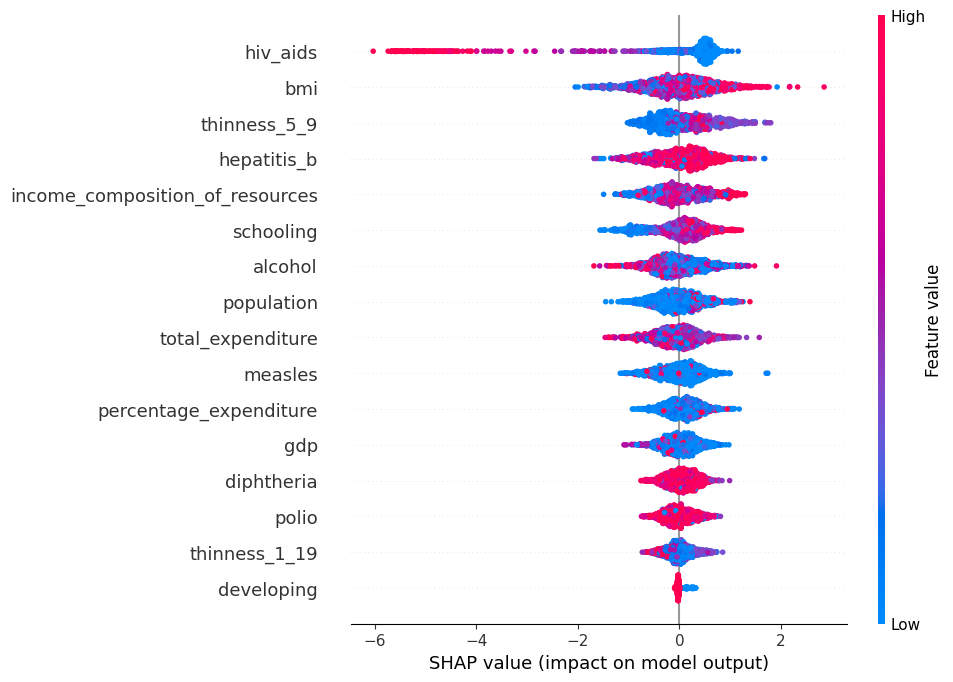

In [30]:
# SHAP summary of all features
shap.plots.beeswarm(shap_values, max_display = 20)

Most fixed predictors make little contribution to the predictions, and their directions are often unclear. A notable exception is the HIV predictor for some extreme observations.

Unlike LGBM, the patterns for GPB are not discontinious and mostly seem random. Possibly another indicator that the booster doesn't learn as well as it could. 

Or maybe these are the "true" fixed effects, and LGBM simply learn noise? But that would mean at least similar predictive performances, and not a large advantage for LGBM. Besides, LMM also learns more significant fixed effects & performs better.

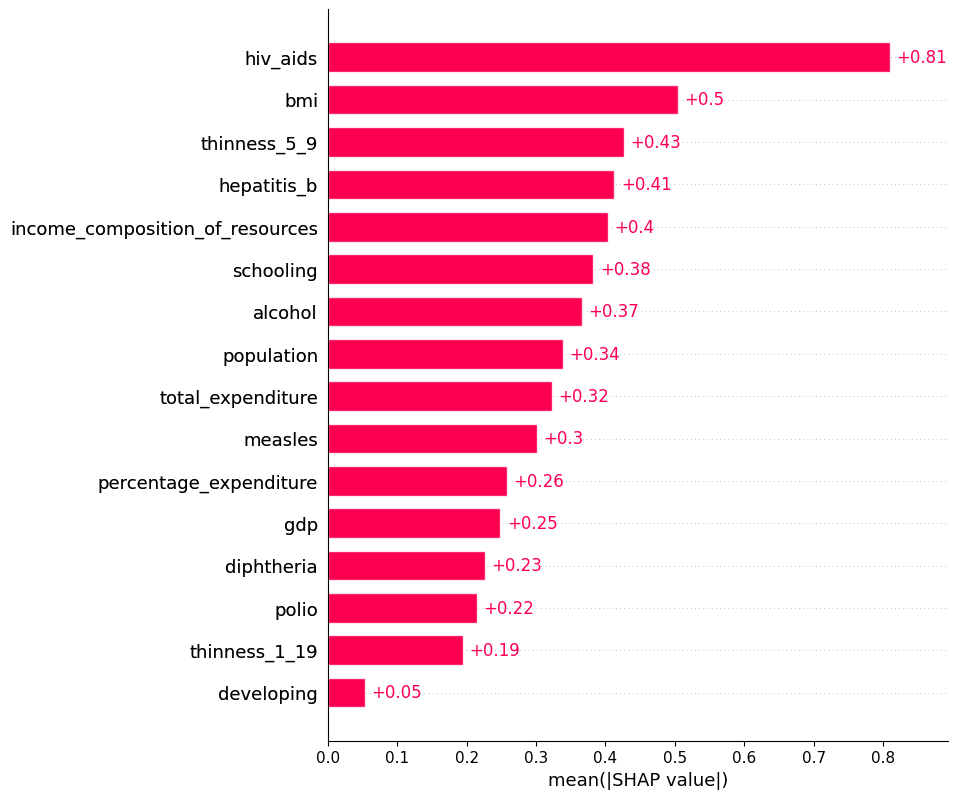

In [36]:
shap.plots.bar(shap_values, max_display = 20)

In [37]:
# Retrieve & plot average contribution of random effects to predictions for each group
re = G.copy()
re["random_effect"] = fitted_random
re_country = re.groupby("country").random_effect.mean().sort_values(ascending = False)
re_year = re.groupby("year").random_effect.mean()

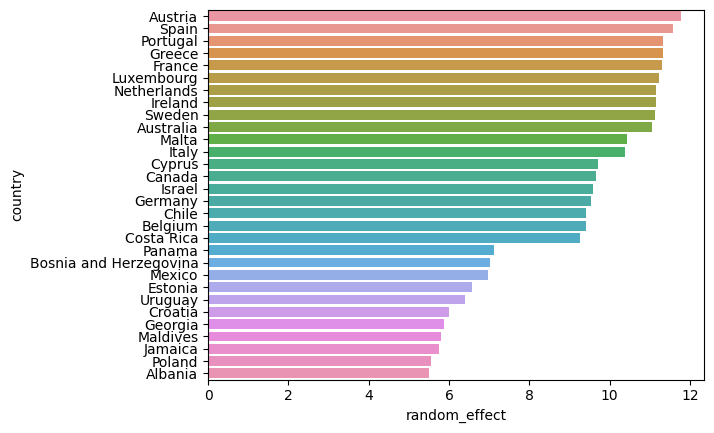

In [38]:
# Countries, top 30
_ = sns.barplot(x = re_country[0:30], y = re_country[0:30].index)

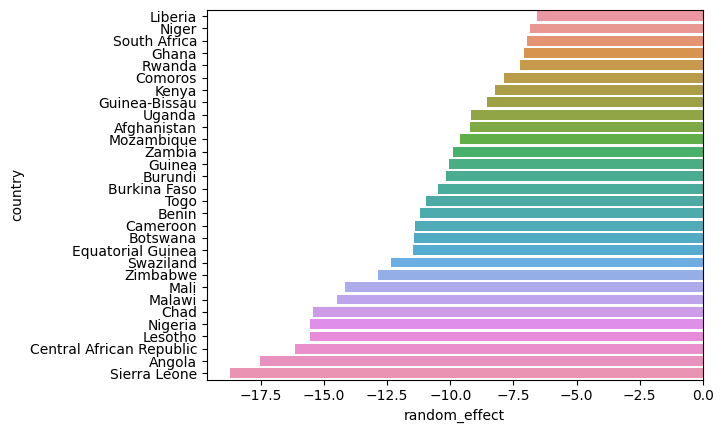

In [39]:
# Countries, bottom 30
_ = sns.barplot(x = re_country[-30:], y = re_country[-30:].index)

The countries with the highest and lowest average fitted random prediction components make sense intuitively.

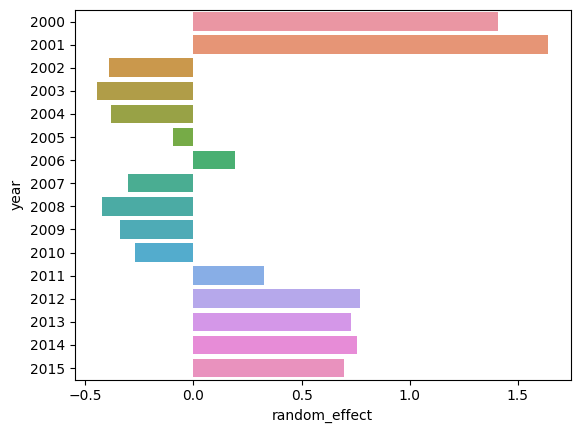

In [40]:
# Years
_ = sns.barplot(x = re_year, y = re_year.index.astype(str))

The year random effect averages don't seem too intuitive or significant.